In [1]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import pathlib
import random
import IPython.display as display

from IPython import display

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
cartoon_image_path = os.listdir('../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k')
cartoon_image_path = [os.path.join("../input/cartoonfacedatasetzip/cartoon_face_dataset/cartoonset10k", x) for x in cartoon_image_path]

cim = []
for x in cartoon_image_path:
    if x[-3:]=='png':
        cim.append(x)
cartoon_image_path = cim
len(cartoon_image_path)

10000

In [5]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #image = ndi.gaussian_filter(image, 5)
    image = tf.image.resize_images(image, [58, 58])
    image = tf.image.central_crop(central_fraction=0.55, image=image)
    #image = tf.image.rgb_to_grayscale(image)
    image -= 127.5
    image /= 127.5  # normalize to [-1,1] range
    return image

def load_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [6]:
cartoon_path_ds = tf.data.Dataset.from_tensor_slices(cartoon_image_path)
cartoon_image_ds = cartoon_path_ds.map(load_image, num_parallel_calls=AUTOTUNE)

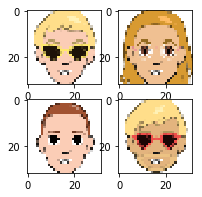

(32, 32, 3)


In [7]:
def show_images(images, l=2, epoch=-1):
    plt.figure(figsize=(l*1.5,l*1.5))
    for n,image in enumerate(images):
        image = (image + 1 ) / 2 #scale to [0,1]
        plt.subplot(l,l,n+1)
        plt.imshow(image)
        plt.grid(False)
    plt.show()
    print(image.shape)
    if epoch!=-1:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
show_images(cartoon_image_ds.take(4))

In [8]:
cartoon_BATCH_SIZE = 32
cartoon_ds = cartoon_image_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(cartoon_image_path)))
cartoon_ds = cartoon_ds.batch(cartoon_BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
cartoon_ds = cartoon_ds.prefetch(buffer_size=AUTOTUNE)
cartoon_ds

<DatasetV1Adapter shapes: (?, 32, 32, 3), types: tf.float32>

In [9]:
for cartoon in cartoon_ds:
    test_cartoon = cartoon
    break
    
print(test_cartoon.shape)

(32, 32, 32, 3)


In [10]:
test_cartoon = test_cartoon[:4]

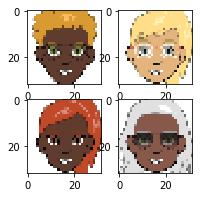

(32, 32, 3)


In [11]:
show_images(test_cartoon)

In [12]:
print(np.max(test_cartoon))
print(np.min(test_cartoon))

1.0
-1.0


In [13]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Reshape((4, 4, 512)))
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 4, 4, 256)         1

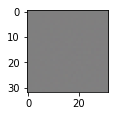

(32, 32, 3)


In [15]:
noise_dim = 100
noise = tf.random_normal([1, noise_dim])
gen_out = generator(noise)
show_images(gen_out, l=1)

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32,32,3)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    #model.add(tf.keras.layers.Activation('sigmoid'))

    return model

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)        

In [18]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [19]:
def discriminator_loss(real_out, generated_out):
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_out), real_out)
    generated_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(generated_out), generated_out)
    total_loss = real_loss + generated_loss
    return total_loss

In [20]:
g_optimizer = tf.train.AdamOptimizer(1e-3, beta1=0.5)
d_optimizer = tf.train.AdamOptimizer(1e-3, beta1=0.5)

In [21]:
2.5e-4

0.00025

In [22]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [23]:
'''def train_step(cartoon_images):
    
    noises = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])
    for noise, cartoon_image in zip(noises, cartoon_images):
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

            # generating noise from a normal distribution

            generated_image = generator(noise, training = True)

            real_out = discriminator(cartoon_image, training =True)
            generated_out = discriminator(generated_image, training = True)

            gen_loss = generator_loss(generated_out)
            dis_loss = discriminator_loss(real_out, generated_out)

        gen_grad = gen_tape.gradient(gen_loss, generator.variables)
        dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)

        g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
        d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))
'''

'def train_step(cartoon_images):\n    \n    noises = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])\n    for noise, cartoon_image in zip(noises, cartoon_images):\n        \n        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:\n\n            # generating noise from a normal distribution\n\n            generated_image = generator(noise, training = True)\n\n            real_out = discriminator(cartoon_image, training =True)\n            generated_out = discriminator(generated_image, training = True)\n\n            gen_loss = generator_loss(generated_out)\n            dis_loss = discriminator_loss(real_out, generated_out)\n\n        gen_grad = gen_tape.gradient(gen_loss, generator.variables)\n        dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)\n\n        g_optimizer.apply_gradients(zip(gen_grad, generator.variables))\n        d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))\n'

In [24]:
def train_step(cartoon_images):
            
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

        noise = tf.random_normal([cartoon_BATCH_SIZE, noise_dim])
        # generating noise from a normal distribution
        generated_images = generator(noise, training = True)

        real_out = discriminator(cartoon_images, training = True)
        generated_out = discriminator(generated_images, training = True)

        gen_loss = generator_loss(generated_out)
        dis_loss = discriminator_loss(real_out, generated_out)

    gen_grad = gen_tape.gradient(gen_loss, generator.variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)

    g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
    d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))


In [25]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [26]:
def generate_test_prediction(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    
    gen_out = generator(test_input, training=False)
    show_images(gen_out, 4, epoch=epoch)
    #print(discriminator(gen_out[:4]))
    #print(discriminator(test_cartoon))
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [27]:
gen_out = generator(random_vector_for_generation, training=False)
print(np.max(gen_out))
print(np.min(gen_out))

0.027964046
-0.029258015


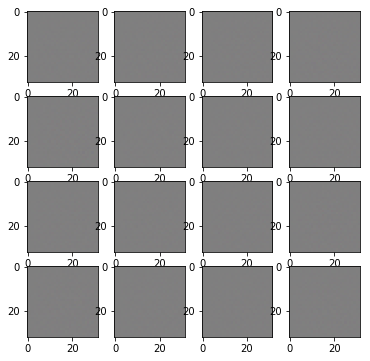

(32, 32, 3)


<Figure size 432x288 with 0 Axes>

In [28]:
generate_test_prediction(generator, 4, random_vector_for_generation)

In [29]:
def train(epochs):
    epoch = 0
    start = time.time()
    for cartoon_images in cartoon_ds:
        train_step(cartoon_images)
        epoch = epoch + 1
        if(epoch%10==0):
            #display.clear_output(wait = True)
            generate_test_prediction(generator, epoch, random_vector_for_generation)
        print ('Time taken for epoch {} is {} sec'.format(epoch, time.time()-start))
        start = time.time()
        if epoch == epochs:
            break

In [30]:
EPOCHS = 100

Time taken for epoch 1 is 34.082783699035645 sec
Time taken for epoch 2 is 1.072098970413208 sec
Time taken for epoch 3 is 1.0736699104309082 sec
Time taken for epoch 4 is 1.0765199661254883 sec
Time taken for epoch 5 is 1.0678315162658691 sec
Time taken for epoch 6 is 1.0762734413146973 sec
Time taken for epoch 7 is 1.0708134174346924 sec
Time taken for epoch 8 is 1.0693590641021729 sec
Time taken for epoch 9 is 1.074774980545044 sec


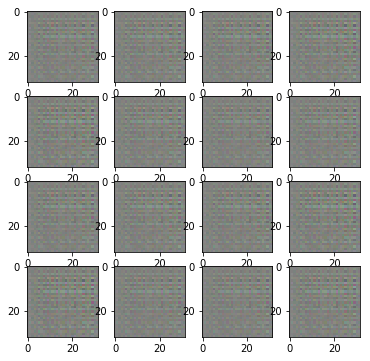

(32, 32, 3)
Time taken for epoch 10 is 2.132441759109497 sec
Time taken for epoch 11 is 1.0719983577728271 sec
Time taken for epoch 12 is 1.0592041015625 sec
Time taken for epoch 13 is 1.0691969394683838 sec
Time taken for epoch 14 is 1.0689129829406738 sec
Time taken for epoch 15 is 1.0480525493621826 sec
Time taken for epoch 16 is 1.0709049701690674 sec
Time taken for epoch 17 is 1.0720584392547607 sec
Time taken for epoch 18 is 1.0683350563049316 sec
Time taken for epoch 19 is 1.0544540882110596 sec


<Figure size 432x288 with 0 Axes>

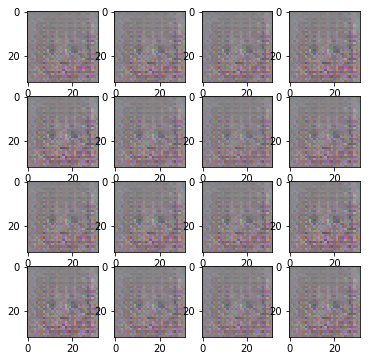

(32, 32, 3)
Time taken for epoch 20 is 2.141935110092163 sec
Time taken for epoch 21 is 1.0800111293792725 sec
Time taken for epoch 22 is 1.0733110904693604 sec
Time taken for epoch 23 is 1.0675981044769287 sec
Time taken for epoch 24 is 1.0618071556091309 sec
Time taken for epoch 25 is 1.0883219242095947 sec
Time taken for epoch 26 is 1.1085851192474365 sec
Time taken for epoch 27 is 1.0905044078826904 sec
Time taken for epoch 28 is 1.0756723880767822 sec
Time taken for epoch 29 is 1.0730164051055908 sec


<Figure size 432x288 with 0 Axes>

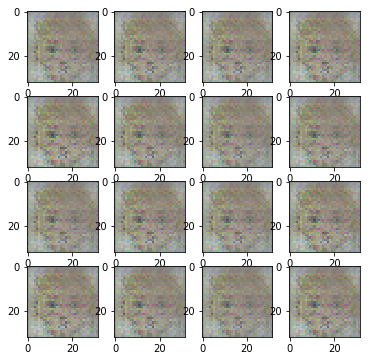

(32, 32, 3)
Time taken for epoch 30 is 2.2828986644744873 sec
Time taken for epoch 31 is 1.067821979522705 sec
Time taken for epoch 32 is 1.0451405048370361 sec
Time taken for epoch 33 is 1.055041790008545 sec
Time taken for epoch 34 is 1.0584216117858887 sec
Time taken for epoch 35 is 1.066821575164795 sec
Time taken for epoch 36 is 1.0901134014129639 sec
Time taken for epoch 37 is 1.10500168800354 sec
Time taken for epoch 38 is 1.1042304039001465 sec
Time taken for epoch 39 is 1.1053431034088135 sec


<Figure size 432x288 with 0 Axes>

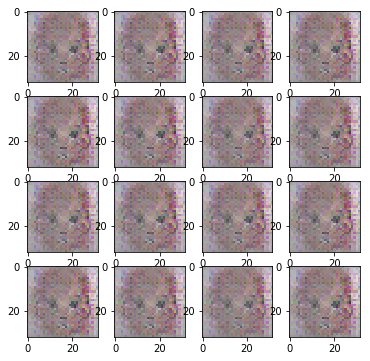

(32, 32, 3)
Time taken for epoch 40 is 2.154230833053589 sec
Time taken for epoch 41 is 1.1251685619354248 sec
Time taken for epoch 42 is 1.0954270362854004 sec
Time taken for epoch 43 is 1.084181547164917 sec
Time taken for epoch 44 is 1.0816547870635986 sec
Time taken for epoch 45 is 1.0460259914398193 sec
Time taken for epoch 46 is 1.0713305473327637 sec
Time taken for epoch 47 is 1.0600230693817139 sec
Time taken for epoch 48 is 1.0513331890106201 sec
Time taken for epoch 49 is 1.069823980331421 sec


<Figure size 432x288 with 0 Axes>

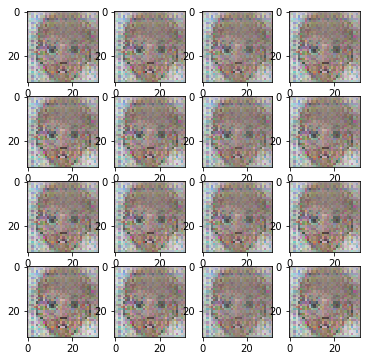

(32, 32, 3)
Time taken for epoch 50 is 2.107151985168457 sec
Time taken for epoch 51 is 1.094444990158081 sec
Time taken for epoch 52 is 1.0636334419250488 sec
Time taken for epoch 53 is 1.061438798904419 sec
Time taken for epoch 54 is 1.0440690517425537 sec
Time taken for epoch 55 is 1.0478248596191406 sec
Time taken for epoch 56 is 1.055694818496704 sec
Time taken for epoch 57 is 1.0668468475341797 sec
Time taken for epoch 58 is 1.0529391765594482 sec
Time taken for epoch 59 is 1.0508801937103271 sec


<Figure size 432x288 with 0 Axes>

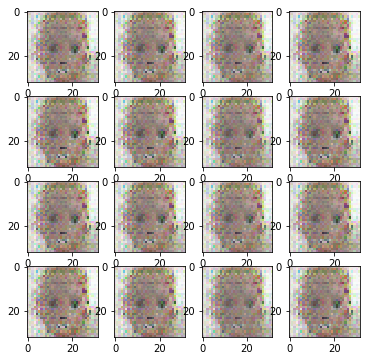

(32, 32, 3)
Time taken for epoch 60 is 2.082115650177002 sec
Time taken for epoch 61 is 1.0601255893707275 sec
Time taken for epoch 62 is 1.0449573993682861 sec
Time taken for epoch 63 is 1.0563273429870605 sec
Time taken for epoch 64 is 1.0567805767059326 sec
Time taken for epoch 65 is 1.0616357326507568 sec
Time taken for epoch 66 is 1.0501642227172852 sec
Time taken for epoch 67 is 1.072030782699585 sec
Time taken for epoch 68 is 1.0628201961517334 sec
Time taken for epoch 69 is 1.0509343147277832 sec


<Figure size 432x288 with 0 Axes>

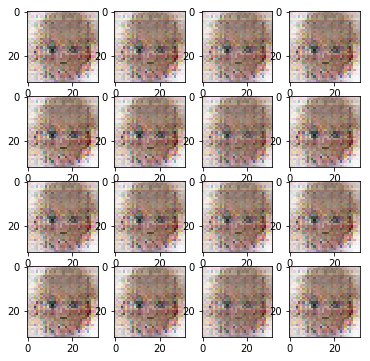

(32, 32, 3)
Time taken for epoch 70 is 2.089445114135742 sec
Time taken for epoch 71 is 1.0526022911071777 sec
Time taken for epoch 72 is 1.19718337059021 sec
Time taken for epoch 73 is 1.3408832550048828 sec
Time taken for epoch 74 is 1.3490300178527832 sec
Time taken for epoch 75 is 1.3528363704681396 sec
Time taken for epoch 76 is 1.2074880599975586 sec
Time taken for epoch 77 is 1.070068597793579 sec
Time taken for epoch 78 is 1.0701098442077637 sec
Time taken for epoch 79 is 1.0434808731079102 sec


<Figure size 432x288 with 0 Axes>

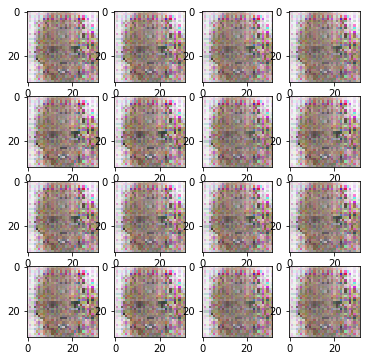

(32, 32, 3)
Time taken for epoch 80 is 2.2653326988220215 sec
Time taken for epoch 81 is 1.0660161972045898 sec
Time taken for epoch 82 is 1.0264413356781006 sec
Time taken for epoch 83 is 1.0365567207336426 sec
Time taken for epoch 84 is 1.035937786102295 sec
Time taken for epoch 85 is 1.0391185283660889 sec
Time taken for epoch 86 is 1.0437469482421875 sec
Time taken for epoch 87 is 1.026994228363037 sec
Time taken for epoch 88 is 1.0463311672210693 sec
Time taken for epoch 89 is 1.0453627109527588 sec


<Figure size 432x288 with 0 Axes>

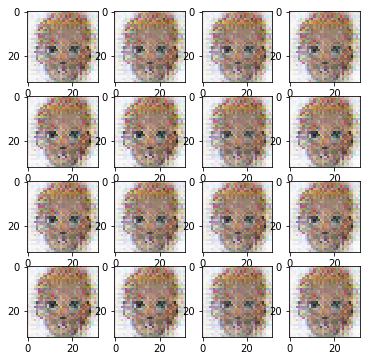

(32, 32, 3)
Time taken for epoch 90 is 2.0664162635803223 sec
Time taken for epoch 91 is 1.0439715385437012 sec
Time taken for epoch 92 is 1.0329763889312744 sec
Time taken for epoch 93 is 1.0338096618652344 sec
Time taken for epoch 94 is 1.061476707458496 sec
Time taken for epoch 95 is 1.0490620136260986 sec
Time taken for epoch 96 is 1.0403447151184082 sec
Time taken for epoch 97 is 1.043989658355713 sec
Time taken for epoch 98 is 1.0303640365600586 sec
Time taken for epoch 99 is 1.0336987972259521 sec


<Figure size 432x288 with 0 Axes>

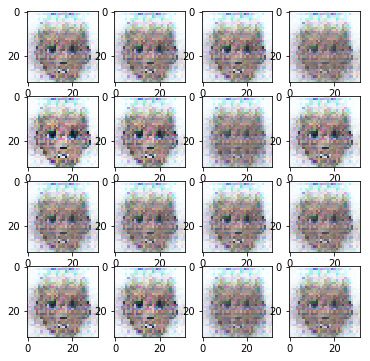

(32, 32, 3)
Time taken for epoch 100 is 2.0630791187286377 sec
CPU times: user 4min 39s, sys: 9.32 s, total: 4min 48s
Wall time: 2min 31s


<Figure size 432x288 with 0 Axes>

In [31]:
%%time
train(EPOCHS)

In [32]:
gen_out = generator(random_vector_for_generation)
print(np.max(gen_out))
print(np.min(gen_out))

0.9999371
-0.93746305


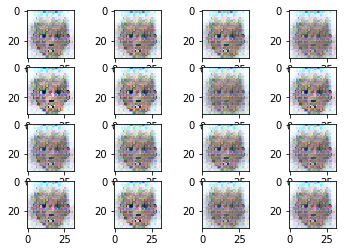

In [33]:
for n,image in enumerate(gen_out):
    image = image/2 + 0.5
    plt.subplot(4,4,n+1)
    plt.imshow(image)
    plt.grid(False)